## Packages and Functions

In [83]:
#Import relevant packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.integrate import odeint
from scipy.integrate import quadrature
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.special import erfc

# Use Latex and serif font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#Variables and Functions
Ga = 3000

#Reads dat file and separates columns into relevant physical variables i.e. time, Amplitude
def read_extract(dat_file):
    df = pd.read_csv(dat_file, sep=' ')
    df.head()
    nb_col = len(df.columns)
    
    if (nb_col==2):
        t = df.iloc[:, 0].to_numpy()
        Amp = df.iloc[:, 1].to_numpy()
        A0 = Amp[0]
        return A0, t, Amp
    
    else :
        t = df.iloc[:, 0].to_numpy()
        AmpOcean = df.iloc[:, 1].to_numpy()
        AmpIce = df.iloc[:, 2].to_numpy()
        A0_Ocean = AmpOcean[0]
        A0_Ice = AmpIce[0]
        return A0_Ocean, A0_Ice, t, AmpOcean, AmpIce
    
#Define ODE function without integral
def model0_0(a,t):
    dadt = a[1]
    d2adt2 = -16 * (np.pi**2 / np.sqrt(Ga)) * dadt - 2 * np.pi * a[0]
    return [dadt,d2adt2]

#Define the ODE with integral
def model(t,a,guess):
    dadt = a[1]
    interpolator = interp1d(guess[:,0], guess[:,1], kind='linear')
    integral_term, _ = quadrature(lambda m: integrate_term(t,m)* interpolator(m), 0, t, tol=1e-11, rtol=1e-9, maxiter=2000)
    d2adt2 = -16 * (np.pi**2 / np.sqrt(Ga)) * dadt - 2 * np.pi * a[0] #+ 64 * (np.pi**4 / Ga) * integral_term
    return [dadt, d2adt2]


#Calculates the f(s) part of the integrand f(s)a(s)
def integrate_term(t, m):
    if (t==0) :    
        c_1 = 1e-12
    else:
        c_1 = (4 * (np.pi**3 / np.sqrt(Ga)) * (t - m))**(-1/2)
    c_2 = np.exp(-4 * (np.pi**2 / np.sqrt(Ga)) * (t - m))
    c_3 = erfc(4 * (np.pi**2 / np.sqrt(Ga)) * (t - m))**(1/2)
    return c_1 * c_2 - c_3

#Calculates the slope for a given data point
def calculate_slope(x_pt, y_pt, i):
    if i < 0 or i >= len(x_pt):
        return None  
    if i == 0:
        slope = (y_pt[i+1] - y_pt[i]) / (x_pt[i+1] - x_pt[i])
    elif i == len(dataset) - 1:
        slope = (y_pt[i] - y_pt[i-1]) / (x_pt[i] - x_pt[i-1])
    else:
        slope = (y_pt[i+1] - y_pt[i-1]) / (x_pt[i+1] - x_pt[i-1])
    return slope

## Integro-diff solver
Write a script to solve Prosperetti's equation

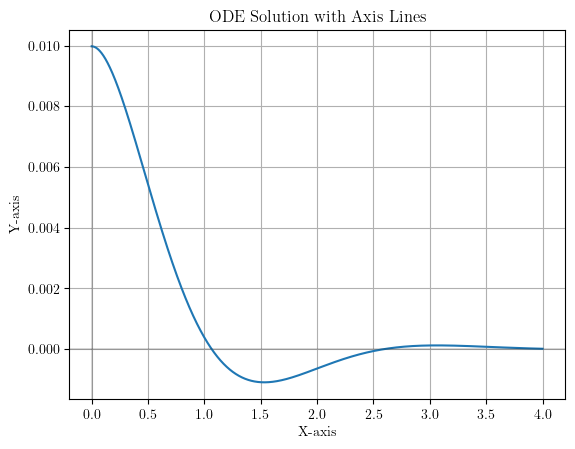

/usr/local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (2000) exceeded. Latest difference = 1.747629e-11
  warnings.warn(
/usr/local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (2000) exceeded. Latest difference = 7.815355e-11
  warnings.warn(
/usr/local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (2000) exceeded. Latest difference = 9.571444e-11
  warnings.warn(
/usr/local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (2000) exceeded. Latest difference = 1.562393e-10
  warnings.warn(
/usr/local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (2000) exceeded. Latest difference = 1.646731e-10
  warnings.warn(
/usr/local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (2000) exceeded. Latest difference = 1.746431e-10
  warning

/usr/local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (2000) exceeded. Latest difference = 1.516346e-11
  warnings.warn(
/usr/local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (2000) exceeded. Latest difference = 1.350540e-11
  warnings.warn(
/usr/local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (2000) exceeded. Latest difference = 1.170906e-11
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


   1: 2.97e-09 1.98e-08


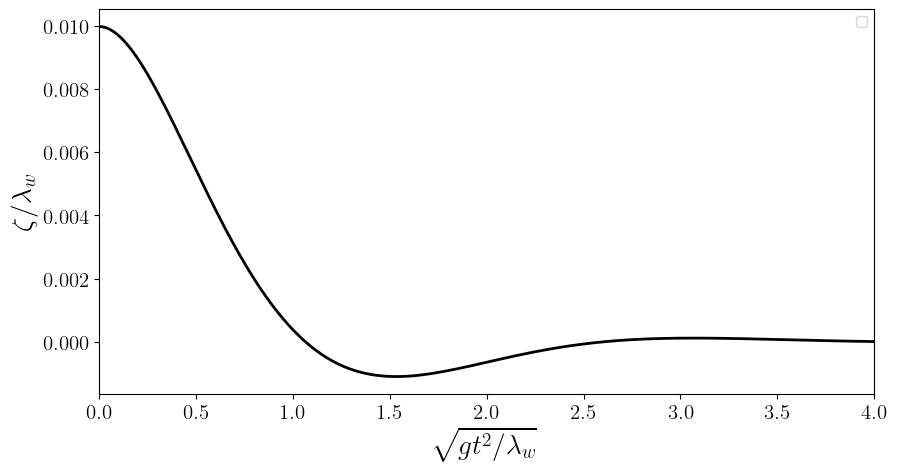

Execution time: 17.32 seconds


In [84]:
##Use integro-diff to solve Prosperetti's equation

#Solves Simple ODE 
t = np.linspace(0, 4, 5000)
a0 = [0.00997592, -1.0999998899934784e-05]
sol0_0 = odeint(model0_0, a0, t)

#Plot Simple ODE a(t) for a check
plt.plot(t, sol0_0[:,0])
plt.axhline(0, color='black', linewidth=0.2)  # Add horizontal line at y=0
plt.axvline(0, color='black', linewidth=0.2)  # Add vertical line at x=0
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('ODE Solution with Axis Lines')
plt.grid(True)  #Add grid lines
plt.show()


#Parameters for solving the ODE 
counter = 1 
err = 1e4 
Tol = np.array([1e-8,1e-8])
t_span = (t[0], t[-1])
guess_data = np.column_stack((t, sol0_0))

# Start measuring the execution time
start_time = time.time()

#Solves the full ODE
while (err > Tol).all():
    sol = solve_ivp(model, t_span, a0, args=(guess_data,), t_eval=t, method='RK45')
    err = np.sum((sol.y-guess_data[:, 1:].T)**2, axis=1)
    formatted_err = [f'{e:8.2e}' for e in err]
    print(f'{counter:4d}: {" ".join(formatted_err)}')
    wt = 0.5
    guess_data = np.column_stack((t, (1-wt)*guess_data[:, 1:] + wt*sol.y.T))
    counter = counter+1
    
    
#Plot a(t) for the full ODE
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(t, sol.y[0], 'k-', lw=2)
ax.set_xlabel(r'$\sqrt{gt^2/\lambda_w}$', fontsize=20)
ax.set_ylabel(r'$\zeta/\lambda_w$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlim([0., 4.0])
#ax.set_ylim([0., max(guess[:,0])])
ax.legend()
plt.show()

# Results for execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

#Sets analytical time 
t_analy = t

## Data from Test Cases

### Comparing Basilisk to Waterwaves

In [79]:
#Import data
A0_ref, t_ref, Amp_ref = read_extract('amplitude.dat')
A0, t, Amp = read_extract('WavesWater_/amplitude.dat')

#WavesWater
#Set plot
fig, ax = plt.subplots(1, 1, figsize=(10,5))

#Data
ax.plot(t_ref, Amp_ref, 'k-', lw=2, label='Data')
ax.plot(t, Amp, 'k-', lw=2, label='Data')

#Specificities
ax.set_xlabel(r'$\sqrt{gt^2/\lambda_w}$', fontsize=20)
ax.set_ylabel(r'$\zeta/\lambda_w$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlim([0., 4.0])
#ax.set_ylim([0., A0])
ax.legend()
#plt.title("Comparison")
#plt.savefig("Comp_mu1e-2A0.01Ga3000.png")
plt.show()

KeyboardInterrupt: 

### Water waves

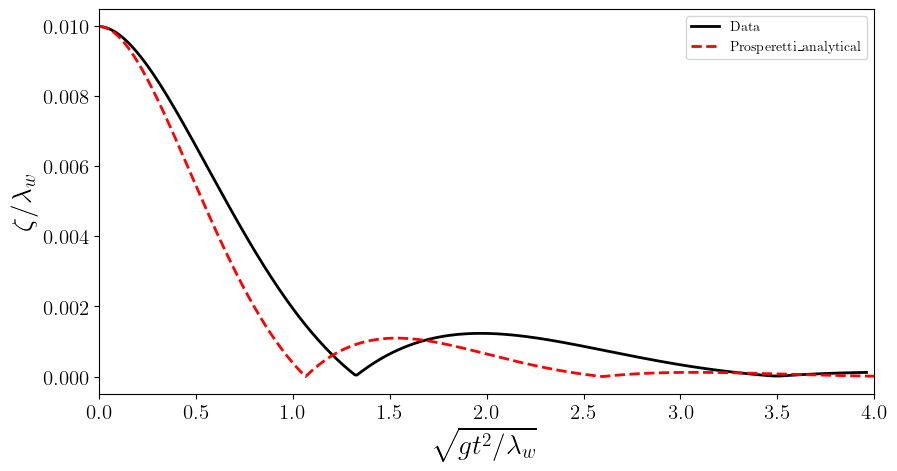

Slope at point 0: -1.0999998899934784e-05
0.00997592


In [85]:
#Import data
A0, t, Amp = read_extract('WavesWater_/amplitude.dat')

#WavesWater
#Set plot
fig, ax = plt.subplots(1, 1, figsize=(10,5))

#Data
ax.plot(t, Amp, 'k-', lw=2, label='Data')
ax.plot(t_analy, abs(sol.y[0]), 'r--', lw=2, label='Prosperetti_analytical')

#Specificities
ax.set_xlabel(r'$\sqrt{gt^2/\lambda_w}$', fontsize=20)
ax.set_ylabel(r'$\zeta/\lambda_w$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlim([0., 4.0])
#ax.set_ylim([0., A0])
ax.legend()
#plt.title("mu1e-2A0.01Ga3000")
#plt.savefig("mu1e-2A0.01Ga3000.png")
plt.show()

point = 0
a_prime_0 = calculate_slope(t,Amp,point)
print(f"Slope at point {point}: {a_prime_0}") #Value for initial condition: A'(0)
print(A0) #Value for initial condition: A(0)

### ViscousOilonWaterWaves

In [ ]:
#ViscousOilOnWaterWaves
A0, t_water, Amp = read_extract('WavesWater_/amplitude.dat')
A0_Ocean, A0_Ice, t_visc, AmpOcean, AmpIce = read_extract('ViscousOilOnWaterWaves_/amplitude.dat')

#Define plot
fig, ax = plt.subplots(1, 1, figsize=(10,5))

#Data
#ax.plot(t_water, Amp, 'r-', lw=2)
ax.plot(t_visc, AmpOcean, 'r-', lw=2)
ax.plot(t_visc, AmpIce, 'k--', lw=2, marker='o', markevery=10)

#Specificities
ax.set_xlabel(r'$\sqrt{gt^2/\lambda_w}$', fontsize=20)
ax.set_ylabel(r'$\zeta/\lambda_w$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax.set_xlim([0., 4.0])
#ax.set_ylim([0., A0])
plt.show()

In [ ]:
A0 = 0.1

df1 = pd.read_csv('WavesWater/amplitude.dat', sep=' ')
df2 = pd.read_csv('ViscousOilOnWaterWaves/amplitude.dat', sep=' ')
df3 = pd.read_csv('IceOnWaterWaves/amplitude.dat', sep=' ')

fig, ax = plt.subplots(1, 1, figsize=(10,5))

t = df1['t']
AmpOcean = df1['AmpOcean']
ax.plot(t, AmpOcean, 'k-', lw=2, marker='o', markevery=10, label='Ocean wave: Water only')

t = df2['t']
Amp = df2['AmpOcean']
AmpIce = df2['AmpIce']

ax.plot(t, Amp, 'r-', lw=2, label='Ocean wave: ocean+oil layer')
ax.plot(t, AmpIce, 'r--', lw=2, marker='o', markevery=10, label='Top surface (liquid-air): ocean+oil layer')


t = df3['t']
Amp = df3['AmpOcean']
AmpIce = df3['AmpIce']

ax.plot(t, Amp, 'b-', lw=2, label='Ocean wave: ocean+ice layer')
ax.plot(t, AmpIce, 'b--', lw=2, marker='o', markevery=10, label='Top surface (liquid-air): ocean+ice layer')


ax.set_xlabel(r'$\sqrt{gt^2/\lambda_w}$', fontsize=20)
ax.set_ylabel(r'$\zeta/\lambda_w$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_xlim([0., 4.0])
ax.set_ylim([0., A0])

ax.legend(loc='best', fontsize=15)

plt.savefig('amplitude.pdf', bbox_inches='tight')

plt.show()

## Integro-diff solver simpler example

In [ ]:
##Test integro-diff solver with simple integro-diff eq 
#relevant packages 
from scipy.integrate import odeint
from scipy.integrate import quadrature
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import time

# Start measuring the execution time
start_time = time.time()

#Define ODE function without and with integral
def model0(a,t):
    dadt = 1.0 - 2.0 *a
    return dadt

def model(t, a, guess):
    interpolator = interp1d(guess[:,0], guess[:,1], kind='linear')
    y, _ = quadrature(lambda s: interpolator(s), 0, t, tol=1e-10, rtol=1e-8, maxiter=1500)
    dadt = 1.0 - 2.0 * a - 5.0 * y
    return dadt


#Calculate the simple diff eq solution
t = np.linspace(0, 10, 100)
a0 = 0
sol0 = odeint(model0, a0, t)

#Parameters for getting precise solution to ODE
counter = 1 
err = 1e4 
Tol = 1e-8
guess_data = np.column_stack((t, sol0))
t_span = (t[0], t[-1])

#Solves the integro diff eq until the solution is precise enough
while err > Tol:
    sol = solve_ivp(model, t_span, [a0], args=(guess_data,), t_eval=t, method='RK45')
    err = sum((sol.y[0]-guess_data[:,1])**2)
    print(f'{counter:4d}: {err:8.2e}')
    wt = 0.5
    guess_data = np.column_stack((t, (1-wt)*guess_data[:,1] + wt*sol.y[0]))
    counter = counter+1

# Plot the solution
plt.plot(t, sol.y[0])
plt.show()

#Execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")